# Smolin state on ibmq_singapore

In [16]:
# qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.qobj import QasmQobj
from qiskit.result import Result
import qiskit.quantum_info as qi
from qiskit.assembler import disassemble
from qiskit.visualization import circuit_drawer

# own code
import workinglib as wl
import likelihood_maximisation as lm
import partitioning as pt

# other tools
import json
import pickle
import numpy as np
import itertools as it
import more_itertools as mit
import matplotlib as plt

## Submitted circuits and simulation

We first load the data with the transpiled circuits as they were run on the physical device.

In [17]:
#Load input data
with open('data/smolin_state/job-5ec2e7bb9ee866001371764f/5ec2e7bb9ee866001371764f-input.json', 'r') as read_file:
    input_data = json.load(read_file)

# Create qiskit QasmQobj with it
qobj = QasmQobj.from_dict(input_data)

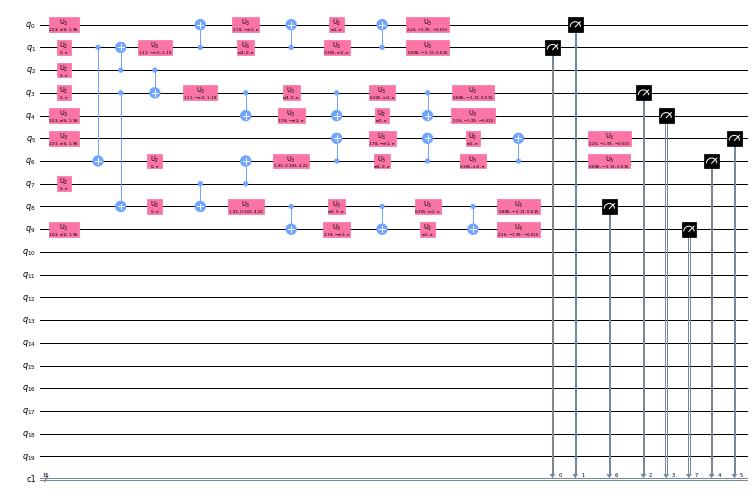

In [18]:
# Draw one of the circuits
dis_qobj = disassemble(qobj);
circuit_drawer(dis_qobj[0][0], scale=0.5, fold=-1, output='mpl')

In [19]:
# Define system-ancilla relation of POVM implementation
sys_anc = {1: 0, 6: 5, 3: 4, 8: 9}

To verify that the circuit prepares the Smolin state and appends the SIC-POVM measurements, we simulate the circuit locally using Aer's qasm_simulator and reconstruct the state to compare it with the theoretical expectation.

Once verified, change the value of variable "simulate" to analyse the experimental data.

In [20]:
# Decide whether to generate simulated data from the circuit above or to use the experimental one
simulate = False

nshots = 8192
n_circuits = len(dis_qobj[0])
if simulate:
    job_sim = execute(dis_qobj[0], Aer.get_backend('qasm_simulator'), shots=nshots)
    result = job_sim.result()
else:
    with open('data/smolin_state/job-5ec2e7bb9ee866001371764f/5ec2e7bb9ee866001371764f-output.json', 'r') as read_file:
        experimental_data = json.load(read_file)
    result = Result.from_dict(experimental_data)

In [21]:
# Aggregate all counts
counts = {}
for i in range(n_circuits):
    p_counts = result.get_counts(i)
    for outcome in p_counts:
        if outcome not in counts:
            counts[outcome] = p_counts[outcome]
        else:
            counts[outcome] += p_counts[outcome]
print('Total shots:', sum(counts.values()))
print('Expected:   ', nshots * n_circuits)

Total shots: 163840
Expected:    163840


In [22]:
# Reconstruct all the k-qubit density matrices with k > 1
k_min = 2
k_max = 4
inferred_states = {}
for k in range(k_min, k_max+1):
    print('k =', k)
    print('-'*30)
    
    # Compute all marginal distributions and k-qubit effects
    marginals = wl.compute_all_simplified_marginals(counts, sorted(sys_anc), k=k)
    observables = wl.generate_sicpovm_effects(k, order='Qiskit')

    # Tomographic reconstruction of all states
    inferred_states[k] = {}
    for kple in marginals:
        inferred_states[k][kple] = qi.DensityMatrix(lm.infer_state(marginals, kple, observables))
        if inferred_states[k][kple].is_valid():
            print(kple, '- OK')
        else:
            print('Warning: invalid state for', kple)

k = 2
------------------------------
(1, 3) - OK
(1, 6) - OK
(1, 8) - OK
(3, 6) - OK
(3, 8) - OK
(6, 8) - OK
k = 3
------------------------------
(1, 3, 6) - OK
(1, 3, 8) - OK
(1, 6, 8) - OK
(3, 6, 8) - OK
k = 4
------------------------------
(1, 3, 6, 8) - OK


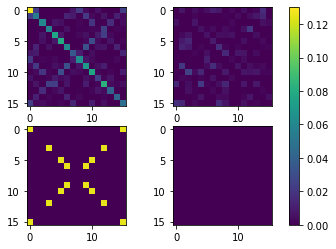

In [23]:
# Expected state
bell = {0: np.array([1, 0, 0, 1]) / np.sqrt(2),
        1: np.array([1, 0, 0, -1]) / np.sqrt(2),
        2: np.array([0, 1, 1, 0]) / np.sqrt(2),
        3: np.array([0, 1, -1, 0]) / np.sqrt(2)}
smolin = np.zeros((16, 16), dtype=complex)
for i in bell:
    bell_dm = np.outer(bell[i], bell[i].conj())
    smolin += np.kron(bell_dm, bell_dm) / 4
smolin = qi.DensityMatrix(smolin)

# Plot simulation/experiment (top) vs expected result (bottom),
# separating real (left) and imaginary (right) parts
fig, ax =  plt.pyplot.subplots(2, 2);
im0 = ax[0][0].imshow(np.real(inferred_states[4][(1,3,6,8)].data), norm=plt.colors.Normalize(0, 0.13));
im1 = ax[0][1].imshow(np.imag(inferred_states[4][(1,3,6,8)].data), norm=plt.colors.Normalize(0, 0.13));
im2 = ax[1][0].imshow(np.real(smolin.data), norm=plt.colors.Normalize(0, 0.13));
im3 = ax[1][1].imshow(np.imag(smolin.data), norm=plt.colors.Normalize(0, 0.13));
fig.colorbar(im0, ax=ax);

## Entanglement structure

With the reconstructed states, we calculate the fidelity and entanglement monotones. We then compare the entanglement values to spurious entanglement in separable states.

In [24]:
# Calculate all quantities and show fidelity
fidelity = {}
entanglement = {}
exact_states = {}
new_index = {q: i for i, q in enumerate(sorted(sys_anc))}
for k in inferred_states:
    print('k =', k)
    print('-'*30)
    fidelity[k] = {}
    entanglement[k] = {}
    exact_states[k] = {}
    for kple in sorted(inferred_states[k]):
        qubit_list = list(range(len(sys_anc)))
        for qubit in kple:
            qubit_list.remove(new_index[qubit])
        exact_states[k][kple] = qi.partial_trace(smolin, qubit_list) if len(kple) < 4 else smolin
        fidelity[k][kple] = np.sqrt(qi.state_fidelity(inferred_states[k][kple], exact_states[k][kple]))
        for P in mit.set_partitions(kple, k=2):
            entanglement[k][(tuple(P[0]), tuple(P[1]))] = wl.negativity_list(inferred_states[k][kple].data, kple, P[0], order='Qiskit', atol=0.0) if k != 2 else qi.concurrence(inferred_states[k][kple])
        print(kple, fidelity[k][kple])

k = 2
------------------------------
(1, 3) 0.9846238253480127
(1, 6) 0.9906264283253887
(1, 8) 0.9814333557191361
(3, 6) 0.9922544827698601
(3, 8) 0.9818912450587912
(6, 8) 0.985425900639291
k = 3
------------------------------
(1, 3, 6) 0.979769476696293
(1, 3, 8) 0.9693451048820734
(1, 6, 8) 0.9766858223886703
(3, 6, 8) 0.9769814735244511
k = 4
------------------------------
(1, 3, 6, 8) 0.6413074399426287


In [25]:
# Calculate entanglemement: concurrence for k = 2, negativity for k > 2
for k in entanglement:
    print('k =', k)
    print('-'*30)
    for kple in sorted(entanglement[k], key=lambda x:min(len(x[0]), len(x[1])) if k>2 else x):
        print(kple, entanglement[k][kple])

k = 2
------------------------------
((1,), (3,)) 0.0
((1,), (6,)) 0.0
((1,), (8,)) 0.0
((3,), (6,)) 0.0
((3,), (8,)) 0.0
((6,), (8,)) 0.0
k = 3
------------------------------
((1,), (3, 6)) 0.0
((1, 3), (6,)) 0.0
((3,), (1, 6)) 0.0
((1,), (3, 8)) 0.0
((1, 3), (8,)) 0.0
((3,), (1, 8)) 0.0
((1,), (6, 8)) 0.0
((1, 6), (8,)) 0.0
((6,), (1, 8)) 0.0
((3,), (6, 8)) 0.0
((3, 6), (8,)) 0.0
((6,), (3, 8)) 0.0
k = 4
------------------------------
((1,), (3, 6, 8)) 0.03546305897278913
((3,), (1, 6, 8)) 0.04063535749076914
((1, 3, 6), (8,)) 0.03476858451386779
((6,), (1, 3, 8)) 0.03121566685667724
((1, 3), (6, 8)) 0.0023492410633511613
((3, 6), (1, 8)) 0.0056343757507692814
((1, 6), (3, 8)) 0.0004853135445532591


In [26]:
# Load distributions of spurious entanglement
negativities_filename = 'data/distributions/neg_res.pkl'
with open(negativities_filename,'rb') as file:
    negativities = pickle.load(file)

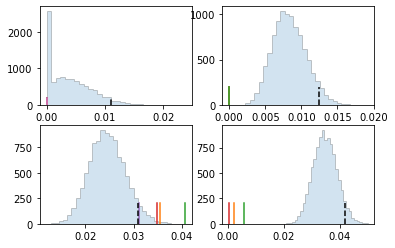

In [27]:
# Plot the results
p = 5e-2
h = 200

fig, ax =  plt.pyplot.subplots(2, 2);
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=30, ec="k", lw=1, log=False)

# Concurrence
n_instances = len(negativities['00_11_state'])
thr = sorted(negativities['00_11_state'])[-int(n_instances * p)]
ax[(0, 0)].hist(negativities['00_11_state'], **kwargs);
for kple in entanglement[2]:
    ax[(0, 0)].plot([entanglement[2][kple], entanglement[2][kple]], [0, h])
ax[(0, 0)].plot([thr, thr], [0, h], ls='--', c='k');

# 3-qubit negativity (1, 2)
n_instances = len(negativities['000_111_state']['100'])
thr = sorted(negativities['000_111_state']['100'])[-int(n_instances * p)]
ax[(0, 1)].hist(negativities['000_111_state']['100'], **kwargs);
for kple in entanglement[3]:
    ax[(0, 1)].plot([entanglement[3][kple], entanglement[3][kple]], [0, h])
ax[(0, 1)].plot([thr, thr], [0, h], ls='--', c='k');

# 4-qubit negativity (1, 3)
n_instances = len(negativities['0011state']['0100'])
thr = sorted(negativities['0011state']['0100'])[-int(n_instances * p)]
ax[(1, 0)].hist(negativities['0011state']['0100'], **kwargs);
for kple in entanglement[4]:
    if min(len(kple[0]), len(kple[1])) == 1:
        ax[(1, 0)].plot([entanglement[4][kple], entanglement[4][kple]], [0, h])
ax[(1, 0)].plot([thr, thr], [0, h], ls='--', c='k');

# 4-qubit negativity (2, 2)
n_instances = len(negativities['0011state']['1100'])
thr = sorted(negativities['0011state']['1100'])[-int(n_instances * p)]
ax[(1, 1)].hist(negativities['0011state']['1100'], **kwargs);
for kple in entanglement[4]:
    if min(len(kple[0]), len(kple[1])) == 2:
        ax[(1, 1)].plot([entanglement[4][kple], entanglement[4][kple]], [0, h])
ax[(1, 1)].plot([thr, thr], [0, h], ls='--', c='k');